In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [13]:
import mechafil
import datetime
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from agentfil import constants
from scenario_generator.gbm_forecast import gbm_forecast

from pycoingecko import CoinGeckoAPI

In [11]:
start_date = datetime.date(2023, 1, 20)
cg = CoinGeckoAPI()
change_t = lambda x : datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
ts = cg.get_coin_market_chart_range_by_id(id='filecoin',
                                          vs_currency='usd',
                                          from_timestamp=time.mktime(constants.NETWORK_DATA_START.timetuple()),
                                          to_timestamp=time.mktime((start_date-datetime.timedelta(days=1)).timetuple()))

usd_fil_exchange_df = pd.DataFrame(
    {
        "coin" : 'filecoin',
        "date" : list(map(change_t, np.array(ts['prices']).T[0])),
        "price" : np.array(ts['prices']).T[1],
        "market_caps" : np.array(ts['market_caps']).T[1], 
        "total_volumes" : np.array(ts['total_volumes']).T[1]
    }
)
usd_fil_exchange_df['date'] = pd.to_datetime(usd_fil_exchange_df['date']).dt.date

In [17]:
num_mc = 100
forecast_length=365
future_prices_vec = []
seed_base = 1111
for ii in range(num_mc):
    seed_in = seed_base + ii
    y = gbm_forecast(usd_fil_exchange_df['price'].values, forecast_length, seed=seed_in)
    future_prices_vec.append(y)

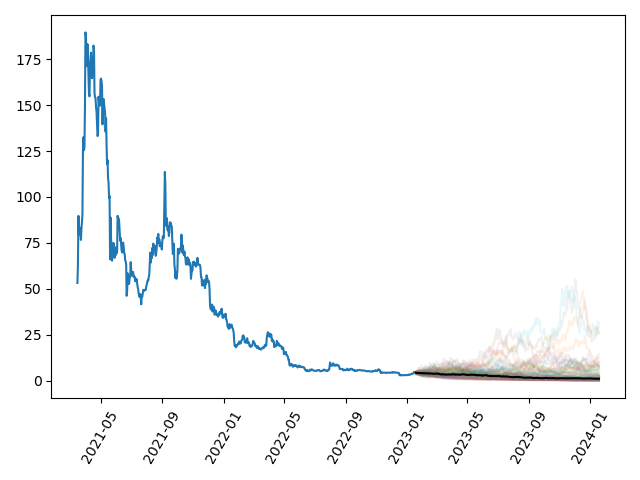

In [26]:
plt.figure()
forecast_start = usd_fil_exchange_df.iloc[-1]['date']
t_vec = [forecast_start + datetime.timedelta(days=ii) for ii in range(forecast_length)]
plt.plot(usd_fil_exchange_df['date'], usd_fil_exchange_df['price'])
for jj in range(num_mc):
    plt.plot(t_vec, future_prices_vec[jj], alpha=0.1)
# plot the median
future_median_price = np.median(np.asarray(future_prices_vec), axis=0)
plt.plot(t_vec, future_median_price, color='k')
plt.xticks(rotation=60)
plt.tight_layout()

In [25]:
np.asarray(future_prices_vec).shape

(100, 365)